# Exploring `.bag` Bathymetry Data Files

An exploration of data and metadata in Bathymetric Attributed Grid (BAG) files.

References:

* BAG website: https://marinemetadata.org/references/bag
* Format Specification Document: http://www.opennavsurf.org/papers/ons_fsd.pdf
* A slightly dated, Python 2 based video lesson on accessing BAG files: https://www.youtube.com/watch?v=dEtC6bRcjvc

Working environment for this notebook:

* Python 3
* `conda` packages:

    * `h5py` - Python interface to HDF5 format used by BAG
    * `lxml` - XML parser and manipulation library to access BAG metadata
    * `numpy` - for n-dimensional arrays
    * `matplotlib` - for plotting
    * `notebook` - Jupyter notebook
    
"Keep Calm and Conda Install"

If you are looking at this in the Salish Sea Tools docs at
http://salishsea-meopar-tools.readthedocs.io/en/latest/bathymetry/ExploringBagFiles.html,
you can find the source notebook that generated the page in the Salish Sea project
[tools repo](https://bitbucket.org/salishsea/tools)
at `tools/bathymetry/ExploringBagFiles.ipynb`
or download the notebook by itself
(instead of cloning the [tools repo](https://bitbucket.org/salishsea/tools) to get it)
from
http://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/tools/raw/tip/bathymetry/ExploringBagFiles.ipynb.

In [1]:
from io import BytesIO

import h5py
from lxml import etree
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

## BAG Dataset

Load the BAG dataset and explore some of its basic attributes:

In [3]:
bag = h5py.File('/ocean/sallen/allen/research/MEOPAR/chs_bathy/092B.bag')

In [4]:
print(type(bag))
print(bag.name)
print(bag.filename)

<class 'h5py._hl.files.File'>
/
/ocean/sallen/allen/research/MEOPAR/chs_bathy/092B.bag


In [5]:
for item in bag.items():
    print(item)
    
for value in bag.values():
    print(value)

('BAG_root', <HDF5 group "/BAG_root" (4 members)>)
<HDF5 group "/BAG_root" (4 members)>


In [6]:
list(bag['BAG_root'].items())

[('elevation', <HDF5 dataset "elevation": shape (337, 448), type "<f4">),
 ('metadata', <HDF5 dataset "metadata": shape (9730,), type "|S1">),
 ('tracking_list', <HDF5 dataset "tracking_list": shape (0,), type "|V20">),
 ('uncertainty', <HDF5 dataset "uncertainty": shape (337, 448), type "<f4">)]

The list above contains the 4 elements that the BAG specification tells us
should be in the file:

* `elevation` is the depths as negative 32-bit floats, with `1.0e6` as the "no data" value (land, typically)
* `metadata` is the BAG metadata, a blob of XML
* `tracking_list` is adjustments to the `elevation` data values made by a hydrographer
* `uncertainty` is the vertical uncertainty in the `elevation` data values

Note that under Python 3 the `h5py` library maked heavy use of `memoryview` objects
which are iterators.
The transformation to a `list` object above,
or the use of a `for` loop above that collects the items from the `memoryview`.

One odd thing to note is that the metadata is stored as a collection of 1-character strings
which turn out to be single bytes in Python 3.
We're going to have to do something about that...

Peeling away the HDF5 group layer:

In [7]:
root = bag['BAG_root']
print(root.name)
print(root.parent)
list(root.items())

/BAG_root
<HDF5 group "/" (1 members)>


[('elevation', <HDF5 dataset "elevation": shape (337, 448), type "<f4">),
 ('metadata', <HDF5 dataset "metadata": shape (9730,), type "|S1">),
 ('tracking_list', <HDF5 dataset "tracking_list": shape (0,), type "|V20">),
 ('uncertainty', <HDF5 dataset "uncertainty": shape (337, 448), type "<f4">)]

## The `elevation` Element

Pulling the `elevation` dataset out of the BAG,
and the depths data out of the dataset:

In [8]:
elev_node = root['elevation']
print(type(elev_node))

<class 'h5py._hl.dataset.Dataset'>


In [9]:
elev = elev_node.value
print(type(elev))

<class 'numpy.ndarray'>


In [10]:
print(elev.min(), elev.max())

-341.917 1e+06


As noted above `1e+06` indicates no data at a point,
typically meaning land.
Let's replace those with NumPy `NaN`s so that we can work with the data more easily:

In [11]:
elev[elev > 9e5] = np.NAN
print(np.nanmin(elev), np.nanmax(elev))

-341.917 4.2


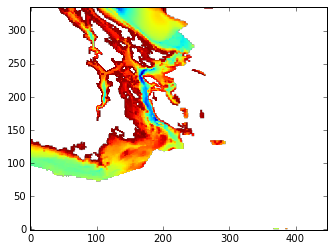

In [12]:
fig, ax = plt.subplots(1, 1)
ax.imshow(elev)
ax.invert_yaxis()

## The `metadata` Element

Pulling the `metadata` element out of the BAG,
and getting it into a form that we can work with:

In [13]:
metadata_node = root['metadata']
print(type(metadata_node))
print(metadata_node)

<class 'h5py._hl.dataset.Dataset'>
<HDF5 dataset "metadata": shape (9730,), type "|S1">


As noted above,
the metadata is a collection of single characters in the form of bytes.
We need to collect those bytes into a buffer and parse them to get an XML tree object
that we can work with in code:

In [14]:
buffer = BytesIO(metadata_node.value)
tree = etree.parse(buffer)
root = tree.getroot()

Now we can get a somewhat readable rendering of the metadata in all its verbose XML glory:

In [15]:
print(etree.tostring(root, pretty_print=True).decode('ascii'))

<gmi:MI_Metadata xmlns:gmi="http://www.isotc211.org/2005/gmi" xmlns:gmd="http://www.isotc211.org/2005/gmd" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:gml="http://www.opengis.net/gml/3.2" xmlns:gco="http://www.isotc211.org/2005/gco" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:bag="http://www.opennavsurf.org/schema/bag">
  <gmd:fileIdentifier>
    <gco:CharacterString>2db1df98-90f2-4e20-a91e-6089111e2f5d</gco:CharacterString>
  </gmd:fileIdentifier>
  <gmd:language>
    <gmd:LanguageCode codeList="http://www.loc.gov/standards/iso639-2/" codeListValue="eng">eng</gmd:LanguageCode>
  </gmd:language>
  <gmd:characterSet>
    <gmd:MD_CharacterSetCode codeList="http://www.isotc211.org/2005/resources/Codelist/gmxCodelists.xml#MD_CharacterSetCode" codeListValue="utf8">utf8</gmd:MD_CharacterSetCode>
  </gmd:characterSet>
  <gmd:hierarchyLevel>
    <gmd:MD_ScopeCode codeList="http://www.isotc211.org/2005/resources/Codelist/gmxCodelists.xml#MD_ScopeCode" codeListValue="dataset

To get information out of the tree we need to deal with the
namespaces that are used for the various tags:

In [16]:
root.nsmap

{'bag': 'http://www.opennavsurf.org/schema/bag',
 'gco': 'http://www.isotc211.org/2005/gco',
 'gmd': 'http://www.isotc211.org/2005/gmd',
 'gmi': 'http://www.isotc211.org/2005/gmi',
 'gml': 'http://www.opengis.net/gml/3.2',
 'xlink': 'http://www.w3.org/1999/xlink',
 'xsi': 'http://www.w3.org/2001/XMLSchema-instance'}

Building the tags that we need to get to the resolution,
and then walking the tree to get the resolution and its units:

In [17]:
sri = etree.QName(root.nsmap['gmd'], 'spatialRepresentationInfo').text
adp = etree.QName(root.nsmap['gmd'], 'axisDimensionProperties').text
dim = etree.QName(root.nsmap['gmd'], 'MD_Dimension').text
res = etree.QName(root.nsmap['gmd'], 'resolution').text
res_meas = etree.QName(root.nsmap['gco'], 'Measure').text

In [18]:
resolution = (
    root
    .find('.//{}'.format(sri))
    .find('.//{}'.format(adp))
    .find('.//{}'.format(dim))
    .find('.//{}'.format(res))
    .find('.//{}'.format(res_meas))
)
print(resolution.text, resolution.get('uom'))

500 Metres


There might be a more elegant way of doing the sequence of `find`s above
if one were to dig more deeply into XPATH syntax.

Similarily for the data region boundaries:

In [19]:
id_info = etree.QName(root.nsmap['gmd'], 'identificationInfo').text
bag_data_id = etree.QName(root.nsmap['bag'], 'BAG_DataIdentification').text
extent = etree.QName(root.nsmap['gmd'], 'extent').text
ex_extent = etree.QName(root.nsmap['gmd'], 'EX_Extent').text
geo_el = etree.QName(root.nsmap['gmd'], 'geographicElement').text
geo_bb = etree.QName(root.nsmap['gmd'], 'EX_GeographicBoundingBox').text

west_bound_lon = etree.QName(root.nsmap['gmd'], 'westBoundLongitude').text
east_bound_lon = etree.QName(root.nsmap['gmd'], 'eastBoundLongitude').text
north_bound_lat = etree.QName(root.nsmap['gmd'], 'northBoundLatitude').text
south_bound_lat = etree.QName(root.nsmap['gmd'], 'southBoundLatitude').text

decimal = etree.QName(root.nsmap['gco'], 'Decimal').text

In [20]:
bbox = (
    root
    .find('.//{}'.format(id_info))
    .find('.//{}'.format(bag_data_id))
    .find('.//{}'.format(extent))
    .find('.//{}'.format(ex_extent))
    .find('.//{}'.format(geo_el))
    .find('.//{}'.format(geo_bb))
)
west_lon = (
    bbox
    .find('.//{}'.format(west_bound_lon))
    .find('.//{}'.format(decimal))
)
print('west:', west_lon.text)

east_lon = (
    bbox
    .find('.//{}'.format(east_bound_lon))
    .find('.//{}'.format(decimal))
)
print('east:', east_lon.text)

north_lat = (
    bbox
    .find('.//{}'.format(north_bound_lat))
    .find('.//{}'.format(decimal))
)
print('north:', north_lat.text)

south_lat = (
    bbox
    .find('.//{}'.format(south_bound_lat))
    .find('.//{}'.format(decimal))
)
print('south:', south_lat.text)

west: -124.003
east: -121.996
north: 49.0024
south: 47.9995
